In [1]:
import pandas as pd
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
import sys
import seaborn as sns

BLOOD_MICROBIOME_DIR = '/home/groups/dpwall/briannac/blood_microbiome/'
BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'
CONC_FILE= BLOOD_MICROBIOME_DIR + '/data/decontam/concentrations.csv'
ABUNDANCE_FILE_EXACT_ALL=BLOOD_MICROBIOME_DIR + 'data/kraken_align/abundances_exact_all.tsv'

IHART_FLAGSTAT_FILE = '/home/groups/dpwall/briannac/blood_microbiome/data/ihart_flagstat.csv'

ABUNDANCE_FILE_CHILDREN_ALL=BLOOD_MICROBIOME_DIR + 'data/kraken_align/abundances_children_all.tsv'
TAXONOMY_FILE = '/home/groups/dpwall/briannac/blood_microbiome/data/kraken_align/taxonomies.tsv'
TAXONOMY_MPA_FILE = '/home/groups/dpwall/briannac/blood_microbiome/data/kraken_align/taxonomies_mpa.tsv'

DATA_OUT_DIR='/home/groups/dpwall/briannac/blood_microbiome/data/kraken_align/'
FIG_OUT_DIR='/home/groups/dpwall/briannac/blood_microbiome/results/kraken_align/'


In [2]:
abundances_exact = pd.read_table(ABUNDANCE_FILE_EXACT_ALL)
abundances_children = pd.read_table(ABUNDANCE_FILE_CHILDREN_ALL)
abundances_exact.name = [n[np.where(np.array(list(n))!=' ')[0][0]:] for n in abundances_exact.name]
abundances_children.name = [n[np.where(np.array(list(n))!=' ')[0][0]:] for n in abundances_children.name]
col_names = sorted(set(abundances_children.columns).intersection(abundances_exact.columns))[::-1]
abundances_exact = abundances_exact[col_names]
abundances_children = abundances_children[col_names]

In [3]:
flagstat = pd.read_csv('/home/groups/dpwall/briannac/blood_microbiome/data/ihart_flagstat.csv', index_col=0)#.loc[col_names[3:]]
flagstat.index = [i.replace('-LCL', '_LCL') for i in flagstat.index]
flagstat = flagstat.loc[col_names[3:]]
bam_mappings = pd.read_table(BAM_MAPPINGS_FILE, index_col=1).loc[col_names[3:]]
bam_mappings.drop('09C86428', inplace=True) # Drop bad sample.

# What general kingdoms/categories did reads go to?

In [4]:
virus = abundances_children[abundances_children.name=='Viruses'].set_index(['tax_id', 'name', 'tax_level'])
bacteria = abundances_children[abundances_children.name=='Bacteria'].set_index(['tax_id', 'name', 'tax_level'])
archaea = abundances_children[abundances_children.name=='Archaea'].set_index(['tax_id', 'name', 'tax_level'])
hg38 = abundances_children[abundances_children.tax_id==9606].set_index(['tax_id', 'name', 'tax_level'])
unmapped = abundances_exact[abundances_exact.tax_level=='U'].set_index(['tax_id', 'name', 'tax_level'])
root = abundances_exact[abundances_exact.tax_level=='R'].set_index(['tax_id', 'name', 'tax_level'])
total_reads = flagstat.Total_Reads - flagstat.Duplicates - flagstat.Supplementary
total_to_map = abundances_exact[col_names[3:]].sum(axis=0)

In [39]:
hg38[list(total_to_map.keys())].values[0]/total_to_map

MH0143019    0.428147
MH0143018    0.389955
MH0143013    0.422670
MH0143009    0.369076
MH0143008    0.433351
               ...   
02C10702     0.314840
02C10543     0.265326
02C10542     0.336327
02C10541     0.310624
02C10540     0.264786
Length: 4569, dtype: float64

In [50]:
a

,,,MH0143019,MH0143018,MH0143013,MH0143009,MH0143008,MH0138989,MH0138055,MH0138054,MH0138052,MH0138051,...,02C10858,02C10857,02C10856,02C10855,02C10704,02C10702,02C10543,02C10542,02C10541,02C10540
tax_id,name,tax_level,,,,,,,,,,,,,,,,,,,,,
1,root,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bacteria,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2157,Archaea,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10239,Viruses,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
a = (bacteria.values[0] + virus.values[0] + archaea.values[0])/(root.values[0] + bacteria.values[0] + archaea.values[0]+virus.values[0])
print(np.nanmedian(a), np.nanpercentile(a, 5), np.nanpercentile(a, 95))


0.6941448572220517 0.503516009025504 0.9492777306411704


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [5]:
df = pd.concat([virus, bacteria, archaea, hg38,unmapped, root]).transpose()
df['total_reads'] = total_reads
df['total_to_realign'] = total_to_map
df.columns = ['Viruses', 'Bacteria', 'Archaea', 'hg38', 'Unmapped', 'Ambiguous', 'Total Reads', 'To realign']
df['Bacteria and Archaea'] = df['Archaea'] + df['Bacteria']
df = df[['Total Reads', 'To realign', 'hg38', 'Bacteria', 'Viruses', 'Archaea', 'Unmapped', 'Ambiguous']]
df_frac = df.apply(lambda x: x/df['To realign'])
df_frac['Total Reads'] = np.nan
df_frac['To realign'] = np.nan
df_frac['sample'] = df_frac.index
df['sample'] = df.index
df.drop('09C86428', inplace=True)

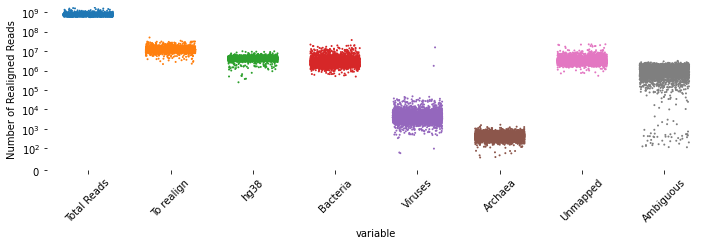

In [6]:
df_melt = df.melt(id_vars='sample')
plt.figure(figsize=(10,3))
ax = sns.stripplot(data=df_melt,  x='variable', y='value', jitter=.3, size=2)
plt.yscale('symlog', linthresh=100)
plt.ylim(0,)
plt.box(on=False)
plt.tight_layout()
plt.ylim(0,)
plt.ylabel('Number of Realigned Reads')
plt.xticks(rotation=45) 
plt.savefig(FIG_OUT_DIR + 'read_distribution.svg', 
            transparent=True, bbox_inches='tight', format='svg')
plt.show()

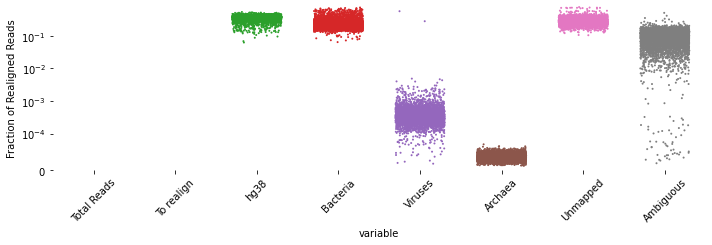

In [7]:
df_melt = df_frac.melt(id_vars='sample')
plt.figure(figsize=(10,3))
ax = sns.stripplot(data=df_melt,  x='variable', y='value', jitter=.3, size=2)
plt.yscale('symlog', linthresh=.0001)
plt.ylim(0,)
plt.ylabel('Fraction of Realigned Reads')
plt.box(on=False)
plt.tight_layout()
plt.xticks(rotation=45) 
plt.savefig(FIG_OUT_DIR + 'read_distribution_fractional.svg', 
            transparent=True, bbox_inches='tight', format='svg')
plt.show()

## Which level of taxonomy did KRAKEN hit?

In [53]:
abundances_grouped = abundances_exact.copy()
abundances_grouped['tax_level'] = [t[0] for t in abundances_grouped.tax_level]
abundances_grouped = abundances_grouped[abundances_grouped.tax_id!=9606].drop(['tax_id', 'name'], axis=1).groupby('tax_level').sum()
abundances_grouped['tax_level'] = abundances_grouped.index 

In [83]:
a = ((abundances_grouped.loc['S']/abundances_grouped[abundances_grouped.columns[:-1]].loc[['D', 'P', 'C', 'O', 'F', 'G', 'S']].sum()).values)

print(np.median(a), np.percentile(a, 5), np.percentile(a,95))

0.5801709642977791 0.44111238852995655 0.7735327744429128


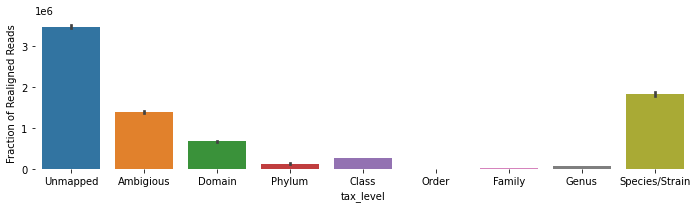

In [32]:
df_melt = abundances_grouped.melt(id_vars='tax_level')
df_melt = df_melt[df_melt.tax_level!='K']
df_melt = df_melt.replace(
    'U', 'Unmapped').replace(
    'R', 'Ambigious').replace(
    'D', 'Domain').replace(
    'P', 'Phylum').replace(
    'C', 'Class').replace(
    'O', 'Order').replace(
    'F', 'Family').replace(
    'G', 'Genus').replace(
    'S', 'Species/Strain')

plt.figure(figsize=(10,3))
ax = sns.barplot(data=df_melt,  x='tax_level', y='value', order=['Unmapped', 'Ambigious', 'Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species/Strain'])
plt.ylabel('Fraction of Realigned Reads')
plt.box(on=False)
plt.tight_layout()
plt.savefig(FIG_OUT_DIR + 'kraken_classification.svg', 
            transparent=True, bbox_inches='tight', format='svg')
plt.show()

In [33]:
abundances_tax_level = abundances_children.copy()
abundances_tax_level = abundances_tax_level[abundances_tax_level.tax_level=='P'].set_index('name')
abundances_tax_level = abundances_tax_level.iloc[np.argsort(abundances_tax_level[col_names[3:]].sum(axis=1))[::-1]].iloc[1:]

# Filtering

In [34]:
### Filter
abundances_species = abundances_children[abundances_children.tax_level=='S']

In [35]:
abundance = abundances_species[col_names[3:]].max(axis=1).values
prev = (abundances_species[col_names[3:]]>0).mean(axis=1).values

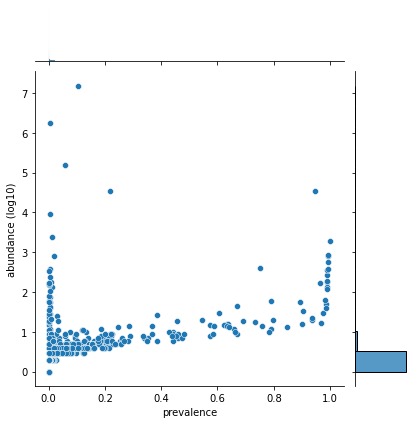

In [36]:
df = pd.DataFrame()
df['virus'] = ['virus' if 'virus' in n else 'bacteria' for n in abundances_species.name]
df['prevalence'] = prev
df['abundance (log10)'] = np.log10(abundance+1)
sns.jointplot(data=df[df.virus=='virus'], x='prevalence', y='abundance (log10)')

In [37]:
viruses = abundances_species[['virus' in n for n in abundances_species.name]].set_index(['tax_level', 'tax_id', 'name'])
virus_filt = viruses[(viruses.max(axis=1)>=100) | ((viruses>=5).mean(axis=1)>=.05)]
print(len(virus_filt))
virus_filt.to_pickle(DATA_OUT_DIR + 'virus_filtered_species.df')

51


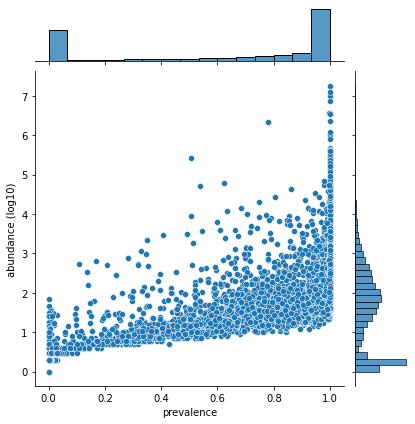

In [38]:
sns.jointplot(data=df[df.virus=='bacteria'], x='prevalence', y='abundance (log10)')

In [39]:
bacteria = abundances_species[['virus' not in n for n in abundances_species.name]].set_index(['tax_level', 'tax_id', 'name'])
bacteria_filt = bacteria[(bacteria.max(axis=1)>=1000) | ((bacteria>=100).mean(axis=1)>=.05)]
print(len(bacteria_filt))
bacteria_filt.to_pickle(DATA_OUT_DIR + 'bacteria_filtered_species.df')

1453


In [40]:
microbes_filt = pd.concat([bacteria_filt, virus_filt])
microbes_filt.index = [i[2] for i in microbes_filt.index]
microbes_filt.to_csv(DATA_OUT_DIR + 'microbe_filtered_species.tsv', sep='\t')

## OLD

In [41]:
rare_but_high = abundances_species[(prev<.05) & (abundance>1000)].set_index(['tax_level', 'tax_id', 'name'])
rare_but_high[rare_but_high.columns[rare_but_high.sum()>1000]]

10C117065  10C110451  09C87488  \
tax_level tax_id  name                                                          
S         11856   Squirrel monkey retrovirus           0          0         0   
          72197   Human erythrovirus V9               14          7         9   
          1511900 Primate erythroparvovirus 1       1995       1182      1549   

                                               09C79835  08C73040  07C66485  \
tax_level tax_id  name                                                        
S         11856   Squirrel monkey retrovirus          0      1190      1425   
          72197   Human erythrovirus V9               8         0         0   
          1511900 Primate erythroparvovirus 1      1487         0         0   

                                               07C65814  07C65812  07C65104  \
tax_level tax_id  name                                                        
S         11856   Squirrel monkey retrovirus          0      2426         0   
          72197   Human erythrovirus V9              32         0         7   
          1511900 Primate erythroparvovirus 1      4287         0      1678   

                                               03C21401  03C21396  03C15792  
tax_level tax_id  name                                                       
S         11856   Squirrel monkey retrovirus          0         0         0  
          72197   Human erythrovirus V9            9315        40         7  
          1511900 Primate erythroparvovirus 1   1734466      5547      1063

In [42]:
flagstat = pd.read_csv('/home/groups/dpwall/briannac/blood_microbiome/data/ihart_flagstat.csv', index_col=0)
bam_mappings = pd.read_table(BAM_MAPPINGS_FILE, index_col=1)
samples = set(flagstat.index).intersection(bam_mappings.index)
flagstat = flagstat.loc[samples]
flagstat['sex'] = bam_mappings.loc[samples].sex_numeric

In [73]:
bam_mappings = pd.read_table(BAM_MAPPINGS_FILE, index_col=1)

In [ ]:
# Bracken output
import pandas as pd
from functools import reduce
dfs = [pd.read_table(g, header=0,
                     names=['name', 'tax_id', 'tax', 
                            'kraken_assigned_%s' % g.split('/')[-1].replace('.species.bracken', ''), 
                            'added_%s' % g.split('/')[-1].replace('.species.bracken', ''), 
                            'new_est_%s' % g.split('/')[-1].replace('.species.bracken', ''), 
                            'frac_%s' % g.split('/')[-1].replace('.species.bracken', '')]) for g in glob(
    BLOOD_MICROBIOME_DIR + 'intermediate_files/kraken_align/*.species.bracken')[:1000]]
merged = reduce(lambda x, y: pd.merge(x, y, 'outer', on=['tax_id', 'name', 'tax']), dfs)
merged.set_index(['name', 'tax_id', 'tax'], inplace=True)

In [203]:
merged = reduce(lambda x, y: pd.merge(x, y, 'outer', on=['tax_id', 'name', 'tax']), dfs[:500])
merged.set_index(['name', 'tax_id', 'tax'], inplace=True)

In [407]:
kraken_assigned = merged[[c for c in merged.columns if 'kraken_assigned_' in c]]
kraken_assigned.columns = [c.replace('kraken_assigned_', '') for c in kraken_assigned.columns]

new_est = merged[[c for c in merged.columns if 'new_est_' in c]]
new_est.columns = [c.replace('new_est_', '') for c in new_est.columns]

In [205]:
kraken_assigned.iloc[np.argsort(kraken_assigned.sum(axis=1))[::-1]].head(5)

,,,08C77345,03C21388,03C16646,03C14365,10C106989,08C74770,09C88942,05C43263,09C81687,03C16650,...,05C46545,05C45447,05C45458,04C27812,09C87487,04C37221,05C39067,10C110447,05C45629,04C35829
name,tax_id,tax,,,,,,,,,,,,,,,,,,,,,
Homo sapiens,9606,S,6826832.0,5035383.0,4173410.0,4146184.0,4672994.0,3887002.0,4827378.0,4657080.0,1337316.0,4829116.0,...,4743991.0,5054693.0,4196268.0,4299644.0,4231156.0,3898955.0,4046506.0,4148562.0,6408197.0,4199991.0
Staphylococcus aureus,1280,S,1114458.0,97739.0,152890.0,211010.0,69773.0,480953.0,141981.0,703221.0,190823.0,119131.0,...,60329.0,183087.0,256860.0,88417.0,202632.0,281106.0,46247.0,1265878.0,367800.0,293699.0
Pseudomonas tolaasii,29442,S,11923.0,1860.0,11142.0,5018.0,314452.0,12013.0,5963.0,11241.0,4011.0,14620.0,...,261560.0,5981.0,7619.0,8879.0,187005.0,5549.0,303130.0,6334.0,10718.0,6541.0
Candidatus Portiera aleyrodidarum,91844,S,188474.0,137572.0,88223.0,90680.0,132790.0,81237.0,134204.0,105037.0,37461.0,102320.0,...,124804.0,146050.0,109915.0,96811.0,98184.0,70731.0,96847.0,106103.0,190651.0,85237.0
Plantactinospora sp. BB1,2071627,S,137300.0,81861.0,98032.0,91524.0,62767.0,125996.0,107836.0,146305.0,92400.0,105314.0,...,90874.0,108899.0,91467.0,102175.0,62268.0,64734.0,126972.0,63325.0,120111.0,81707.0


In [429]:
from scipy.stats import ttest_ind
males = kraken_assigned[[c for c in kraken_assigned.columns if bam_mappings.loc[c].sex_numeric=='1.0']]#.apply(lambda x: x/sum(x), axis=1)
females = kraken_assigned[[c for c in kraken_assigned.columns if bam_mappings.loc[c].sex_numeric=='2.0']]#.apply(lambda x: x/sum(x), axis=1)

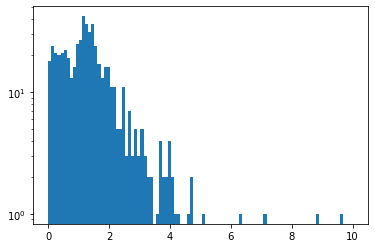

In [430]:
pvals = np.array([ttest_ind((males.iloc[i]+1), (females.iloc[i]+1)).pvalue for i in range(len(males))])
plt.hist(-np.log10(pvals), bins=np.linspace(0,10,100))
plt.yscale('log')

In [431]:
kraken_assigned.iloc[pvals<(.05/len(pvals))]

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


,,,08C77345,03C21388,03C16646,03C14365,10C106989,08C74770,09C88942,05C43263,09C81687,03C16650,...,05C46545,05C45447,05C45458,04C27812,09C87487,04C37221,05C39067,10C110447,05C45629,04C35829
name,tax_id,tax,,,,,,,,,,,,,,,,,,,,,
Clostridium pasteurianum,1501,S,971.0,1140.0,735.0,675.0,218.0,594.0,729.0,212.0,66.0,826.0,...,771.0,811.0,841.0,519.0,507.0,705.0,169.0,361.0,925.0,305.0
Clostridium sporogenes,1509,S,240.0,670.0,209.0,176.0,243.0,382.0,392.0,209.0,14.0,489.0,...,468.0,204.0,72.0,597.0,449.0,319.0,284.0,275.0,249.0,170.0
Streptomyces glomeroaurantiacus,68210,S,376.0,281.0,278.0,222.0,209.0,275.0,260.0,294.0,59.0,319.0,...,287.0,287.0,223.0,298.0,213.0,274.0,204.0,220.0,344.0,276.0
Streptomyces platensis,58346,S,101.0,71.0,83.0,79.0,33.0,99.0,76.0,132.0,50.0,110.0,...,79.0,90.0,103.0,84.0,49.0,47.0,74.0,61.0,91.0,80.0
Mycoplasma sp. NEAQ87857,2683967,S,473.0,803.0,280.0,705.0,263.0,686.0,889.0,519.0,243.0,913.0,...,698.0,866.0,441.0,989.0,543.0,904.0,372.0,385.0,1049.0,744.0
Cupriavidus basilensis,68895,S,126.0,45.0,39.0,167.0,48.0,192.0,137.0,86.0,29.0,176.0,...,184.0,151.0,44.0,168.0,30.0,175.0,32.0,133.0,153.0,175.0
Ehrlichia chaffeensis,945,S,261.0,209.0,315.0,221.0,182.0,179.0,211.0,200.0,31.0,262.0,...,184.0,218.0,188.0,177.0,246.0,314.0,157.0,154.0,299.0,182.0
Blattabacterium cuenoti,1653831,S,23506.0,17523.0,2814.0,23530.0,5456.0,17229.0,19556.0,1696.0,18191.0,27066.0,...,22287.0,18128.0,2088.0,25595.0,25985.0,49674.0,1834.0,25155.0,25071.0,19062.0
Flavobacterium psychrophilum,96345,S,1691.0,1772.0,621.0,1810.0,1680.0,866.0,943.0,990.0,248.0,1267.0,...,877.0,1243.0,603.0,1532.0,1482.0,1240.0,892.0,851.0,1307.0,1125.0


In [434]:
bam_mappings.loc['02C10540'].sex_numeric

'1.0'

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


('Clostridium pasteurianum', 1501, 'S')


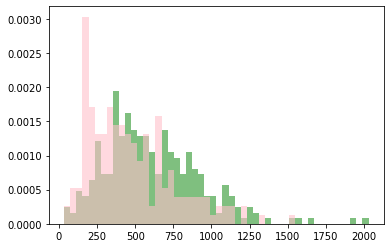

('Clostridium sporogenes', 1509, 'S')


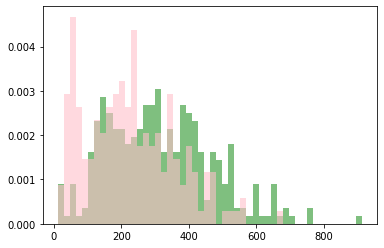

('Streptomyces glomeroaurantiacus', 68210, 'S')


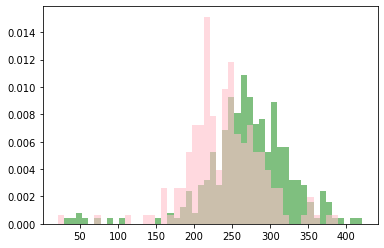

('Streptomyces platensis', 58346, 'S')


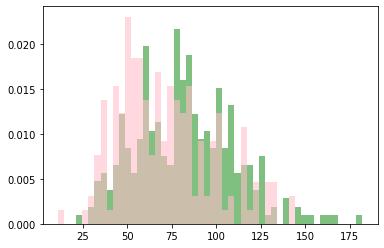

('Mycoplasma sp. NEAQ87857', 2683967, 'S')


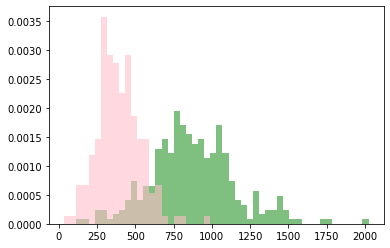

('Cupriavidus basilensis', 68895, 'S')


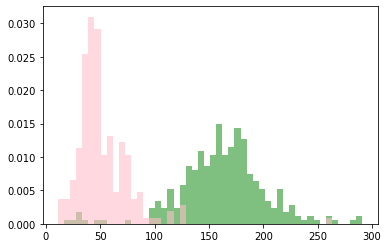

('Ehrlichia chaffeensis', 945, 'S')


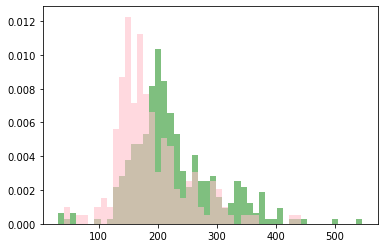

('Blattabacterium cuenoti', 1653831, 'S')


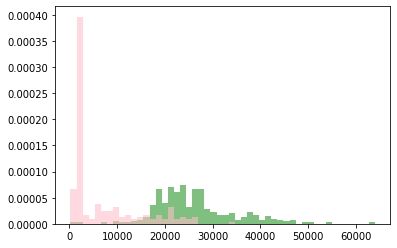

('Flavobacterium psychrophilum', 96345, 'S')


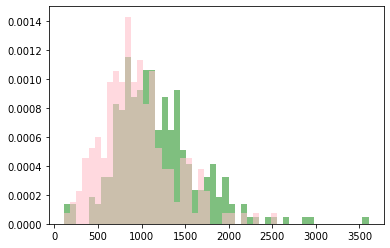

('Hydrogenobaculum sp. Y04AAS1', 380749, 'S')


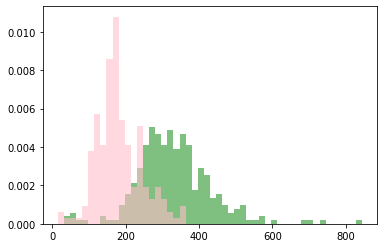

In [432]:
#new_est.iloc[np.argsort(pvals)]
for sex_bacteria in kraken_assigned.iloc[pvals<(.05/len(pvals))].index:
    print(sex_bacteria)
    n= plt.hist(kraken_assigned.loc[sex_bacteria].values, alpha=0, density=True, bins=50)
    plt.hist(males.loc[sex_bacteria].values, alpha=.5, bins=n[1], color='green', density=True)
    plt.hist(females.loc[sex_bacteria].values, alpha=.6, bins=n[1], color='pink', density=True)
    plt.show()

In [285]:
mannwhitneyu(np.log10(males.iloc[0].values),np.log10(females.iloc[0].values), alternative=;)

MannwhitneyuResult(statistic=27002.0, pvalue=0.05928990290555187)

In [271]:
np.median(females.iloc[1:].sum().values)

1042228.0

08C77345     1114458.0
03C21388       97739.0
03C16646      152890.0
03C14365      211010.0
10C106989      69773.0
               ...    
04C37221      281106.0
05C39067       46247.0
10C110447    1265878.0
05C45629      367800.0
04C35829      293699.0
Name: (Staphylococcus aureus, 1280, S), Length: 500, dtype: float64


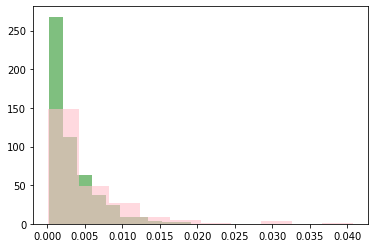

In [246]:
#new_est.iloc[np.argsort(pvals)]
i = 0
print(kraken_assigned.iloc[i+1])
plt.hist(males.iloc[i].values, alpha=.5, color='green', density=True)
plt.hist(females.iloc[i].values, alpha=.6, color='pink', density=True)
plt.show()

(array([196.39972588,  14.28361643,   4.28508493,   1.42836164,
          1.42836164,   0.71418082,   1.42836164,   0.        ,
          0.        ,   1.42836164]),
 array([0.00070254, 0.00521933, 0.00973612, 0.01425291, 0.01876971,
        0.0232865 , 0.02780329, 0.03232008, 0.03683687, 0.04135367,
        0.04587046]),
 <BarContainer object of 10 artists>)

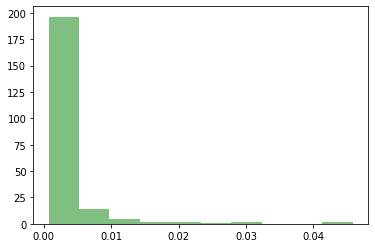

In [242]:
plt.hist(males.iloc[i].values, alpha=.5, color='green', density=True)


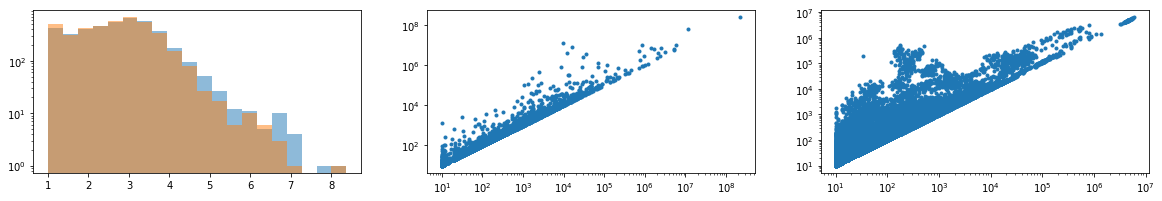

In [68]:
f, ax = plt.subplots(ncols=3, figsize=(20,3))
n = ax[0].hist(np.log10(new_est.sum(axis=1).values), bins=20, alpha=.5)
ax[0].hist(np.log10(kraken_assigned.sum(axis=1).values), bins=n[1], alpha=.5)
ax[0].set_yscale('log')

ax[1].plot(kraken_assigned.sum(axis=1).values, new_est.sum(axis=1).values, '.')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[2].plot(kraken_assigned.values.flatten(), new_est.values.flatten(), '.')
ax[2].set_xscale('log')
ax[2].set_yscale('log')

In [69]:
new_est.iloc[np.argsort(new_est.sum(axis=1))[::-1]].head(20)

,,,08C74770,09C88942,05C43263,09C81687,07C62630,10C113175,05C40764,10C115222,11C122080,09C90890,...,10C112908,07C65919,10C112899,11C125825,07C66579,09C86313,05C41357,10C112902,10C114754,10C114753
name,tax_id,tax,,,,,,,,,,,,,,,,,,,,,
Homo sapiens,9606,S,3981359.0,5145205.0,4831378.0,1393613.0,5341045.0,6089467.0,5726562.0,4109205.0,4687778.0,4498439.0,...,4714969.0,4636926.0,4189143.0,4154206.0,5366684.0,4768523.0,5158869.0,4475162.0,4845659.0,5100836.0
Staphylococcus aureus,1280,S,2259718.0,923431.0,1717172.0,1725414.0,424291.0,1445687.0,428882.0,1379159.0,243257.0,750429.0,...,424806.0,1490329.0,271146.0,343863.0,1862065.0,1471509.0,1462695.0,396461.0,2289250.0,2432042.0
Mannheimia haemolytica,75985,S,108853.0,237379.0,86278.0,189768.0,465991.0,246620.0,259970.0,242152.0,190398.0,87074.0,...,295073.0,151789.0,221405.0,314949.0,128016.0,233150.0,146835.0,378886.0,243548.0,129792.0
Pseudomonas tolaasii,29442,S,15308.0,9825.0,13157.0,7517.0,751584.0,21585.0,879964.0,19184.0,3523.0,6291.0,...,625008.0,1394874.0,717690.0,4650.0,10255.0,14200.0,14552.0,1051318.0,12968.0,8962.0
Escherichia coli,562,S,236716.0,184691.0,146681.0,176544.0,205438.0,202773.0,202729.0,144329.0,177927.0,157148.0,...,153635.0,179582.0,131134.0,167878.0,299407.0,339905.0,219610.0,175085.0,234006.0,181689.0
Escherichia virus phiX174,10847,S,40647.0,202991.0,26253.0,321624.0,218906.0,190643.0,109686.0,191856.0,51122.0,39017.0,...,175662.0,58421.0,125564.0,292387.0,53073.0,105988.0,71828.0,330287.0,188782.0,118912.0
Salmonella enterica,28901,S,89476.0,205977.0,90469.0,71759.0,209871.0,201950.0,195020.0,108248.0,112531.0,108180.0,...,197759.0,100351.0,137775.0,153392.0,126543.0,143877.0,128884.0,165676.0,143042.0,145432.0
Klebsiella pneumoniae,573,S,67856.0,126801.0,159824.0,75162.0,40518.0,189495.0,76426.0,198082.0,33790.0,51728.0,...,32407.0,184024.0,31089.0,36216.0,103513.0,106290.0,115143.0,26092.0,370502.0,383678.0
Plantactinospora sp. BB1,2071627,S,153984.0,128702.0,174511.0,110728.0,162112.0,119450.0,178703.0,92774.0,139543.0,140394.0,...,98924.0,146714.0,103840.0,94399.0,140659.0,123042.0,152485.0,115794.0,118151.0,104783.0


In [2]:
abundances_exact = pd.read_table(ABUNDANCE_FILE_EXACT_ALL, index_col=2) #abundances_exact_paired + abundances_exact_single
abundances_exact = abundances_exact.iloc[np.argsort(abundances_exact.drop(['tax_level', 'tax_id'], axis=1).sum(axis=1)).values[::-1]]

abundances_children = pd.read_table(ABUNDANCE_FILE_CHILDREN_ALL, index_col=2) #abundances_exact_paired + abundances_exact_single
abundances_children = abundances_children.iloc[np.argsort(abundances_children.drop(['tax_level', 'tax_id'], axis=1).sum(axis=1)).values[::-1]]

abundances_exact = abundances_exact[abundances_exact.drop(['tax_level', 'tax_id'], axis=1).sum(axis=1)>0]
abundances_children = abundances_children[abundances_children.drop(['tax_level', 'tax_id'], axis=1).sum(axis=1)>0]

# Save final files.
abundances_exact.to_csv(DATA_OUT_FILE + '/abundances_exact.csv')
abundances_children.to_csv(DATA_OUT_FILE + '/abundances_children.csv')

In [4]:
abundances_children

,tax_level,tax_id,02C10540,02C10541,02C10542,02C10543,02C10702,02C10704,02C10855,02C10856,...,MH0138051,MH0138052,MH0138054,MH0138055,MH0138989,MH0143008,MH0143009,MH0143013,MH0143018,MH0143019
name,,,,,,,,,,,,,,,,,,,,,
root,R,1,9141994,10095877,7438635,10663119,8325114,9444249,7598015,7480613,...,8680326,8034567,10343167,8466470,6326045,8191848,9025076,9251524,8555385,8010790
cellular organisms,R1,131567,8085611,9015779,6945703,9472703,7559197,8732714,6595500,7159985,...,8196638,7765512,9376188,7624089,5441915,8082046,8448170,8970604,7891251,7704935
Homo,G,9605,4031085,5015882,4183931,4833557,3168353,3575853,3531485,3606358,...,4481482,4737301,5638657,4391834,3502544,5002796,4566202,5460285,4730844,4585191
Homininae,F1,207598,4031085,5015882,4183931,4833557,3168353,3575853,3531485,3606358,...,4481482,4737301,5638657,4391834,3502544,5002796,4566202,5460285,4730844,4585191
Mammalia,C,40674,4031085,5015882,4183931,4833557,3168353,3575853,3531485,3606358,...,4481482,4737301,5638657,4391834,3502544,5002796,4566202,5460285,4730844,4585191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Artibeus planirostris polyomavirus 3,S,1606499,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mosquito VEM virus SDRBAJ,S,1034806,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pseudomonas virus KNP,S,1981933,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Load taxonomies

In [161]:
taxonomies = pd.read_csv(TAXONOMY_FILE, sep='\t', header=None)
taxonomies_mpa = pd.read_csv(TAXONOMY_MPA_FILE, sep='\t', header=None)

In [158]:
TAXONOMY_FILE

'/home/groups/dpwall/briannac/blood_microbiome/data/kraken_align/taxonomies.tsv'

In [162]:
taxonomies.columns = ['Percent', 'N_children', 'N_exact', 'tax_level', 'tax_id', 'Name']
taxonomies.index = taxonomies.Name